In [21]:
import torch

from src.utils import *
import os
import IPython.display as ipd
import logging

from src.resnet_model import SpectrogramModel
import torch.nn as nn
import librosa


logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

In [22]:
seed_everything(1234)
set_gpu(-1)
#plt.style.use('dark_background')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
script_dir = os.getcwd()

GPU selected: 1 - Quadro P6000


In [23]:
# https://github.com/hrtlacek/SNR/blob/main/SNR.ipynb
def compute_snr(clean, perturbed):
    noise = clean - perturbed
    signal_power = np.mean(clean**2)
    noise_power = np.mean(noise**2) 

    if noise_power == 0:
        return float('inf')

    snr = 10 * np.log10((signal_power - noise_power)/noise_power)
    return snr

In [24]:
def compute_snr(clean_audio, perturbed_audio):
    """Compute SNR (Signal-to-Noise Ratio) between clean and perturbed audio without RMS normalization."""
    # Ensure both inputs are numpy arrays
    clean_audio = np.array(clean_audio)
    perturbed_audio = np.array(perturbed_audio)
    
    # Compute the noise (perturbation) as the difference between clean and perturbed audio
    noise = clean_audio - perturbed_audio
    
    # Compute the power of the clean signal
    signal_power = np.mean(clean_audio ** 2)
    
    # Compute the power of the noise (perturbation)
    noise_power = np.mean(noise ** 2)
    
    # Avoid division by zero in case of zero noise power
    if noise_power == 0:
        return np.inf  # Infinite SNR if there's no noise
    
    # Calculate SNR in dB
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr

In [25]:
# file_number = 4437704
# 
# attack = 'Ens1D'
# couple = 'RawSEN'
# eps_1 = '0dot005'
# eps_2 ='0dot002'
# q1 = 20
# q2 = 60
# audio_path = os.path.join(script_dir, f'{attack}_{couple}_v0_pow', f'{attack}_{couple}_v0_whole_pow_{q1}_{q2}_{eps_1}_{eps_2}', f'{attack}_{couple}_{q1}_{q2}_v0_pow_LA_E_{file_number}_None.flac')
# audio, _ = librosa.load(audio_path, sr=16000)
# audio = audio[:47104]
# 
# clean_audio_path = os.path.join(script_dir, '..',f'/nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_eval/flac/LA_E_{file_number}.flac')
# clean, _ = librosa.load(clean_audio_path, sr=16000)
# print(len(clean))
# clean = clean[:47104]
# snr = compute_snr(clean, audio)
# print(f'SNR: {snr}')

In [26]:
file_number = 1001964
attack = 'BIM'
attack_model = 'SENet1D'
epsilon = '0dot006'
audio_path = os.path.join(script_dir, f'{attack}_{attack_model}_v0_pow', f'{attack}_{attack_model}_v0_whole_pow_{epsilon}', f'{attack}_{attack_model}_v0_pow_LA_E_{file_number}_{epsilon}.flac')
audio, _ = librosa.load(audio_path, sr=16000)
audio = audio[:47104]

clean_audio_path = os.path.join(script_dir, '..',f'/nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_eval/flac/LA_E_{file_number}.flac')
clean, _ = librosa.load(clean_audio_path, sr=16000)
clean = clean[:47104]
snr = compute_snr(clean, audio)
print(f'SNR: {snr}')

SNR: 42.16512680053711


In [27]:
print(f' clean mean {np.mean(clean)}, max abs {np.max(np.abs(clean))}')
#print(f' clean min {np.min(-clean)}, max {np.max(-clean)}, mean {np.mean(-clean)}, max abs {np.max(np.abs(-clean))}')
print(f' pert mean {np.mean(audio)}, max abs {np.max(np.abs(audio))}')

 clean mean 5.110450274514733e-06, max abs 0.999969482421875
 pert mean 5.1098027142870706e-06, max abs 0.999969482421875


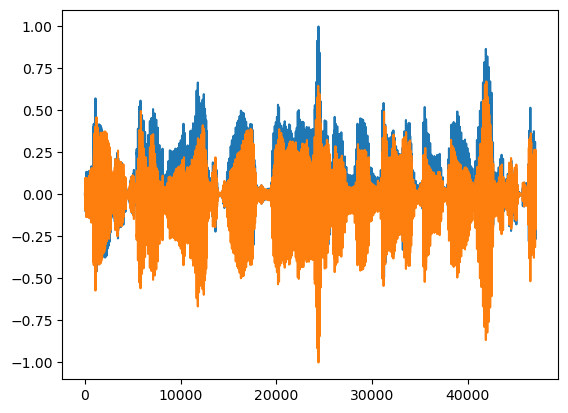

In [28]:
plt.figure()
plt.plot(clean)

plt.plot(-clean)
plt.show()

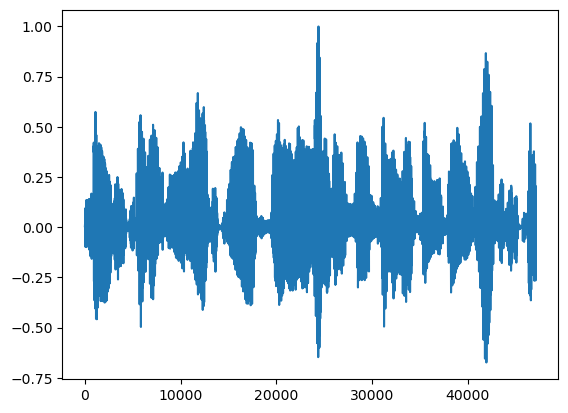

In [29]:
plt.figure()
plt.plot(audio)
plt.show()

In [30]:
ipd.Audio(audio, rate=16000)

In [31]:
ipd.Audio(clean, rate=16000)

In [32]:
y1_normalized = clean / np.max(np.abs(clean))
y2_normalized = audio / np.max(np.abs(audio))

# Calculate Mean Squared Error (MSE)
mse = np.mean((y1_normalized - y2_normalized) ** 2)
print(f"Waveform MSE: {mse:.4f}")

Waveform MSE: 0.0000


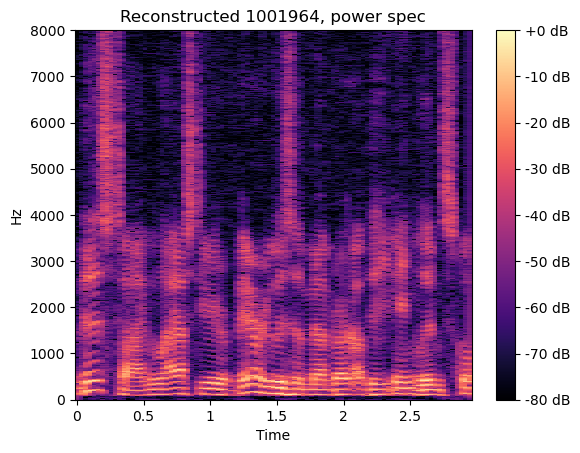

In [33]:
win_length = 2048
n_fft = 2048
hop_length = 512
window = 'hann'

s = librosa.stft(audio, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
phase = np.angle(s)
mag = np.abs(s)

a = np.abs(s) ** 2
pow_spec = librosa.power_to_db(a, ref=np.max)

plt.figure()
librosa.display.specshow(pow_spec, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Reconstructed {file_number}, power spec')
plt.show()

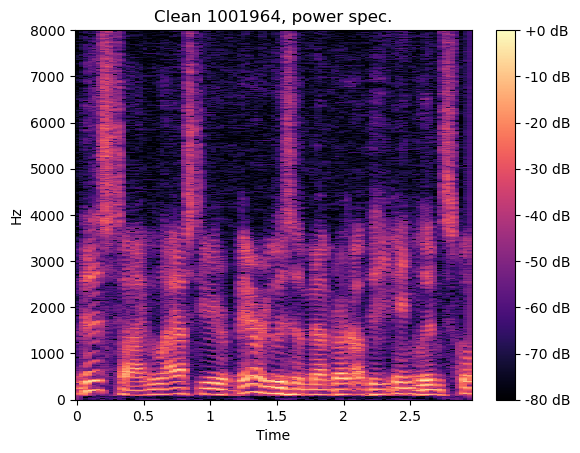

In [34]:
win_length = 2048
n_fft = 2048
hop_length = 512
window = 'hann'

s = librosa.stft(clean, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
phase = np.angle(s)
mag = np.abs(s)

a = np.abs(s) ** 2
pow_spec_c = librosa.power_to_db(a, ref=np.max)

plt.figure()
librosa.display.specshow(pow_spec, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Clean {file_number}, power spec.')
plt.show()

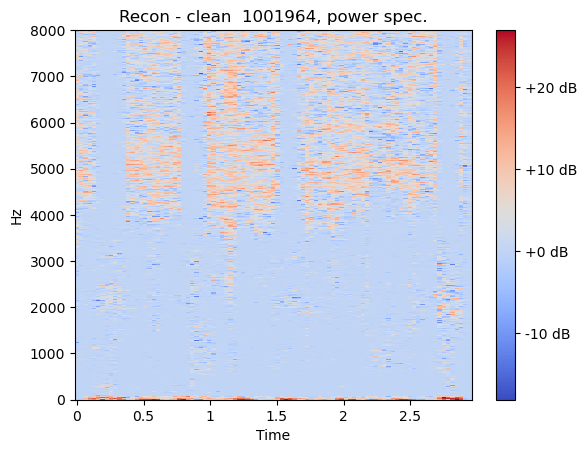

In [35]:
# pert - clean
plt.figure()
librosa.display.specshow(pow_spec - pow_spec_c, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Recon - clean  {file_number}, power spec.')
plt.show()

In [36]:
mse = np.mean((pow_spec - pow_spec_c)**2)
mse

15.304545

In [37]:
from src.ResNet1D.resnet1d_model import SpectrogramModel1D
script_dir = os.getcwd()
parent_dir = os.path.dirname(script_dir)
config_path = os.path.join(parent_dir, 'config', 'resnet1d.yaml')
config = read_yaml(config_path)
check_dir = os.path.join(parent_dir, config['model_path_spec_pow_v0'])
model = SpectrogramModel1D().to(device)
model.load_state_dict(torch.load(check_dir, map_location=device), strict=False)
model.eval()

SpectrogramModel1D(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block1): ResNetBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu): LeakyReLU(negative_slope=0.01)
    (dropout): Dropout(p=0.5, inplace=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (conv11): Conv2d(32, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  )
  (mp): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  (block2): ResNetBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu): LeakyReLU(negative_slope=0.01)
    (dropout): Dropout(p=0.5, inplace=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (conv11

In [38]:
batch_x = torch.from_numpy(audio).unsqueeze(dim=0).to(device)
out = model(batch_x)
print(f'Perturbed file eval {torch.argmax(out)}, {out}')
batch_z = torch.from_numpy(clean).unsqueeze(dim=0).to(device)
outz = model(batch_z)
print(f'clean file eval {torch.argmax(outz)}, {outz}')

Perturbed file eval 1, tensor([[-1.0321e+01, -3.2901e-05]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
clean file eval 1, tensor([[-1.0521e+01, -2.6941e-05]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)


In [39]:
from src.SENet.senet1d_model import se_resnet341d_custom

script_dir = os.getcwd()
parent_dir = os.path.dirname(script_dir)
config_path = os.path.join(parent_dir, 'config', 'senet1d.yaml')
config = read_yaml(config_path)
check_dir = os.path.join(parent_dir, config['model_path_spec_pow_v0'])
model = se_resnet341d_custom(num_classes=2).to(device)
model.load_state_dict(torch.load(check_dir, map_location=device), strict=False)
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SEBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_featu

In [40]:
batch_x = torch.from_numpy(audio).unsqueeze(dim=0).to(device)
out = model(batch_x)
print(f'Perturbed file eval {torch.argmax(out)}, {out}')
batch_z = torch.from_numpy(clean).unsqueeze(dim=0).to(device)
outz = model(batch_z)
print(f'clean file eval {torch.argmax(outz)}, {outz}')

Perturbed file eval 0, tensor([[  0.0000, -18.2525]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
clean file eval 1, tensor([[-1.6754, -0.2073]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [41]:
# from src.LCNN_model.LCNN1d_model import LCNN1D
# 
# script_dir = os.getcwd()
# parent_dir = os.path.dirname(script_dir)
# config_path = os.path.join(parent_dir, 'config', 'LCNN1d.yaml')
# config = read_yaml(config_path)
# check_dir = os.path.join(parent_dir, config['model_path_spec_pow_v0'])
# model = LCNN1D().to(device)
# model.load_state_dict(torch.load(check_dir, map_location=device), strict=False)
# model.eval()

In [42]:
from src.rawnet2_model import RawNet

script_dir = os.getcwd()
parent_dir = os.path.dirname(script_dir)
config_path = os.path.join(parent_dir, 'config', 'rawnet2.yaml')
config = read_yaml(config_path)
check_dir = os.path.join(parent_dir, config['model_path_spec_pow_v0'])
model_cls = RawNet(config['model'], device)
model = model_cls.to(device)
model.load_state_dict(torch.load(check_dir, map_location=device), strict=False)
model.eval()

RawNet(
  (Sinc_conv): SincConv()
  (first_bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (selu): SELU(inplace=True)
  (block0): Sequential(
    (0): Residual_block(
      (lrelu): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=(1,))
      (mp): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block1): Sequential(
    (0): Residual_block(
      (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(20, 20, kernel_size=(3,), stride

In [43]:
batch_x = torch.from_numpy(audio).unsqueeze(dim=0).to(device)
out = model(batch_x)
print(f'Perturbed file eval {torch.argmax(out)}, {out}')
batch_z = torch.from_numpy(clean).unsqueeze(dim=0).to(device)
outz = model(batch_z)
print(f'clean file eval {torch.argmax(outz)}, {outz}')

Perturbed file eval 1, tensor([[-1.2893e+01, -2.5034e-06]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
clean file eval 1, tensor([[-1.2890e+01, -2.5034e-06]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)


In [44]:
clean, _ = librosa.load(clean_audio_path, sr=16000)
len(clean)

105757

In [45]:
# 3s are 16000*3=48000
clean = clean[:48000]
s = librosa.stft(clean, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
s.shape

(1025, 94)

In [46]:
r = librosa.istft(s, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window)
len(r)

47616